In [7]:

import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

model architecture :

In [24]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_dim)).to(device=device)
        out, _ = self.gru(x, h0)#[:, -1, :].unsqueeze(0))
        out = self.fc(out[:,90:,:])
        return out

Prepare dataset:

In [6]:
ratio = 'BTC-USD'
dataset = f'crypto_data/{ratio}.csv' 
data = pd.read_csv(dataset, names=['time', 'low', 'high', 'open', 'close', 'volume'])  # read in specific file


In [7]:
import pandas as pd
import numpy as np

# Normalize the data
data = (data - data.mean()) / data.std()

# Convert the DataFrame to a Torch tensor
data_tensor = torch.from_numpy(data.values).float()

# Split the data into input and target sequences
input_seq = []
target_seq = []
seq_length = 100
pred_length = 10

for i in range(len(data) - seq_length - pred_length):
    input_seq.append(data_tensor[i:i+seq_length, 1:])
    target_seq.append(data_tensor[i+seq_length:i+seq_length+pred_length, -2])

target $\rightarrow$ close

In [8]:
input_seq[0].shape , len(input_seq)

(torch.Size([100, 5]), 97614)

In [9]:
target_seq[0].shape

torch.Size([10])

In [10]:
input_seq = torch.stack(input_seq)
target_seq = torch.stack(target_seq)

In [11]:
input_seq.shape , target_seq.shape

(torch.Size([97614, 100, 5]), torch.Size([97614, 10]))

Set the hyperparameters :


In [12]:
input_dim = 5
hidden_dim = 64
output_dim = 1
num_layers = 2
num_epochs = 100
learning_rate = 0.001

batch_size = 32  # Set your desired batch size

 Initialize the model :


In [30]:

model = GRUNet(input_dim, hidden_dim, output_dim, num_layers).to(device=device)

In [32]:
model(torch.rand(3,100,5).to(device=device)).shape

torch.Size([3, 10, 1])

 Define the loss function and the optimizer :


In [33]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

 Train the model :


In [34]:
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm


define `DataLoader` :

In [35]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [36]:
dataset = StockDataset(input_seq, target_seq)

In [37]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [38]:
for batch_idx, (data, targets) in enumerate(tqdm(dataloader)):
    print(targets.shape, "   <<>>   ",data.shape)
    
    if batch_idx == 10:
        break
    

  0%|          | 10/3051 [00:00<00:03, 798.95it/s]

torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])
torch.Size([32, 10])    <<>>    torch.Size([32, 100, 5])


In [40]:
model(torch.rand(32,100,5).to(device=device)).shape

torch.Size([32, 10, 1])

In [48]:
# Train Network
for epoch in range(num_epochs):
    # losses = []

    for batch_idx, (data, targets) in enumerate(tqdm(dataloader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        #print(scores.shape,"************",targets.unsqueeze(2).shape)
        loss = criterion(scores, targets.unsqueeze(2))

        #losses.append(loss.item())
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

100%|██████████| 3051/3051 [00:11<00:00, 264.47it/s]


Epoch [10/100], Loss: 0.0007


100%|██████████| 3051/3051 [00:10<00:00, 287.06it/s]


Epoch [20/100], Loss: 0.0005


100%|██████████| 3051/3051 [00:08<00:00, 378.94it/s]


Epoch [30/100], Loss: 0.0003


100%|██████████| 3051/3051 [00:09<00:00, 323.86it/s]


Epoch [40/100], Loss: 0.0010


100%|██████████| 3051/3051 [00:09<00:00, 335.10it/s]


Epoch [50/100], Loss: 0.0002


100%|██████████| 3051/3051 [00:09<00:00, 324.38it/s]


Epoch [60/100], Loss: 0.0016


100%|██████████| 3051/3051 [00:09<00:00, 330.81it/s]


Epoch [70/100], Loss: 0.0003


100%|██████████| 3051/3051 [00:11<00:00, 254.37it/s]


Epoch [80/100], Loss: 0.0002


100%|██████████| 3051/3051 [00:08<00:00, 339.83it/s]


Epoch [90/100], Loss: 0.0001


100%|██████████| 3051/3051 [00:13<00:00, 232.11it/s]

Epoch [100/100], Loss: 0.0003


# Evaluation :

test 1:

In [120]:
ratio = 'BTC-USD'
dataset = f'crypto_data/{ratio}.csv' 
data = pd.read_csv(dataset, names=['time', 'low', 'high', 'open', 'close', 'volume']) 
data = (data - data.mean()) / data.std()


In [121]:
test_input = data.loc[91610:91610+99]#.head()
test_input

,time,low,high,open,close,volume
91610,1.575398,-0.523029,-0.523907,-0.525492,-0.521586,0.044329
91611,1.575431,-0.519131,-0.523907,-0.521579,-0.521602,-0.322117
91612,1.575464,-0.519131,-0.523907,-0.521594,-0.521586,-0.212765
91613,1.575497,-0.519131,-0.523907,-0.521594,-0.521602,-0.296088
91614,1.575530,-0.519131,-0.523907,-0.521579,-0.521586,-0.328103
...,...,...,...,...,...,...
91705,1.578544,-0.525353,-0.526058,-0.527816,-0.525780,-0.183906
91706,1.578577,-0.523310,-0.528085,-0.525758,-0.525765,-0.279277
91707,1.578610,-0.523310,-0.528085,-0.525773,-0.525765,-0.311162
91708,1.578643,-0.523310,-0.528085,-0.525773,-0.525765,-0.239356


In [122]:
test_target = data.loc[91610+99:91610+99+9]#.head()
len(test_target)

10

In [123]:
test_target

,time,low,high,open,close,volume
91709,1.578676,-0.523310,-0.528085,-0.525758,-0.525765,-0.319193
91710,1.578709,-0.523310,-0.528085,-0.525758,-0.525780,-0.297730
91711,1.578742,-0.523310,-0.528085,-0.525758,-0.525780,-0.330982
91712,1.578775,-0.523794,-0.528085,-0.525758,-0.526249,-0.301252
91713,1.578808,-0.523794,-0.528569,-0.526241,-0.526264,-0.283438
91714,1.578842,-0.523794,-0.528569,-0.526256,-0.526249,-0.284781
91715,1.578875,-0.523794,-0.528569,-0.526241,-0.526264,-0.329853
91716,1.578908,-0.528456,-0.528569,-0.526256,-0.530926,-0.226253
91717,1.578941,-0.528471,-0.533230,-0.530903,-0.530926,-0.291095
91718,1.578974,-0.528471,-0.533246,-0.530919,-0.530926,-0.209262


Define data :

In [124]:
output = torch.tensor(test_target.values)[:,-2].to(device=device)
output.shape

torch.Size([10])

In [125]:
input = torch.tensor(test_input.values[:,1:],dtype=torch.float).unsqueeze(0).to(device=device)
input.shape

torch.Size([1, 100, 5])

In [126]:
pred = model(input)

In [127]:
# pred.squeeze(0).squeeze(1)
pred_ = torch.Tensor.detach(torch.Tensor.cpu(pred.view(-1))).numpy()
output_ = torch.Tensor.detach(torch.Tensor.cpu(output.view(-1))).numpy()

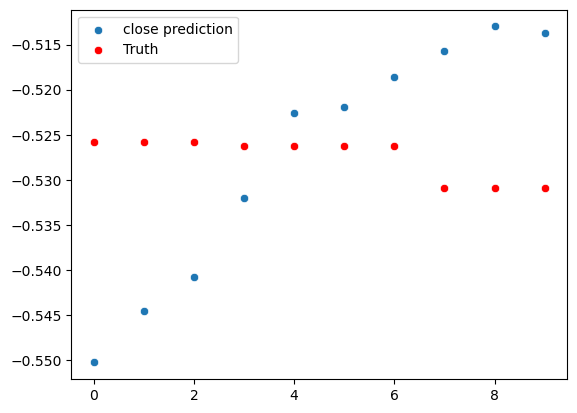

In [136]:

sns.scatterplot(pred_)
sns.scatterplot(output_,color='r')
plt.legend(['close prediction','Truth']);


In [141]:
def plot_resualt(start_index):
    test_input = data.loc[start_index:start_index+99]
    test_target = data.loc[start_index+99:start_index+99+9]
    output = torch.tensor(test_target.values)[:,-2].to(device=device)
    input = torch.tensor(test_input.values[:,1:],dtype=torch.float).unsqueeze(0).to(device=device)
    pred = model(input)

    pred_ = torch.Tensor.detach(torch.Tensor.cpu(pred.view(-1))).numpy()
    output_ = torch.Tensor.detach(torch.Tensor.cpu(output.view(-1))).numpy()

    sns.scatterplot(pred_)
    sns.scatterplot(output_,color='r')
    plt.legend(['close prediction','Truth']);

---
test 2:

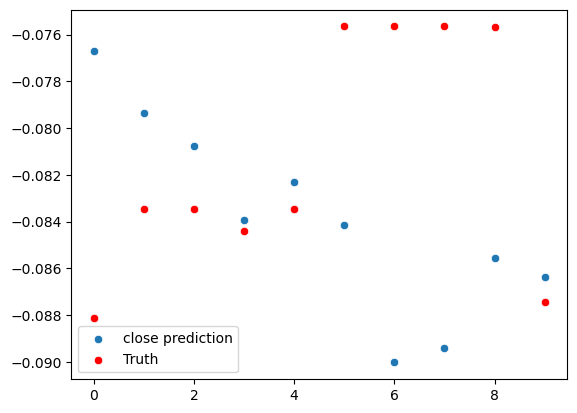

In [142]:
plot_resualt(92610)

test 3:

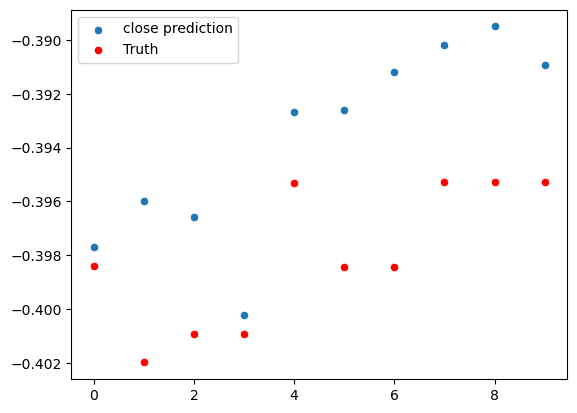

In [143]:
plot_resualt(95610)

test 4:


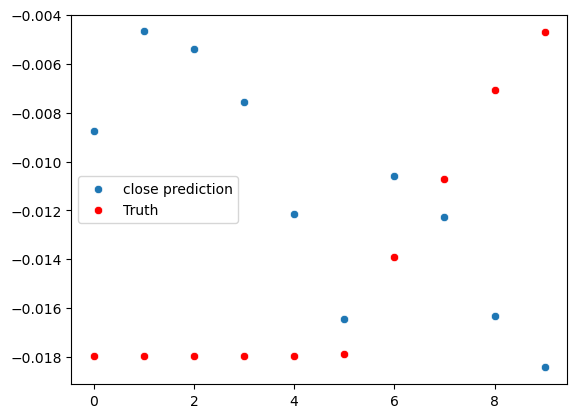

In [145]:
plot_resualt(96810)

 Save model : 


In [10]:
torch.save(model.state_dict(), 'GRU_model_state.pth')

NameError: name 'model' is not defined

Load model : 


In [ ]:
model.load_state_dict(torch.load('model_state.pth'))